# Tâche 9

Calculer les températures de Debye $\theta_D$ et d'Einstein $\theta_E$ telles que les modèles correspondants minimisent l'erreur au sens des moindres carrés sur l'ensemble de la courbe de la chaleur spécifique. Représenter les trois courbes de chaleur spécifique (celle correspondant à l'objet téléchargé ainsi que celles obtenues à partir des modèles de Debye et d'Einstein).
et représenter les trois densités d'états de phonons correspondantes.

In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt  
from scipy import integrate
from scipy.integrate import quad

In [2]:
mp_key = "xaEW7gxeGjtHSTeJuWSz9Uf8JpzNlgtg"
mp_id = "mp-9382"

In [3]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# 1) Chaleur spécifique molaire normalisée à volume constant

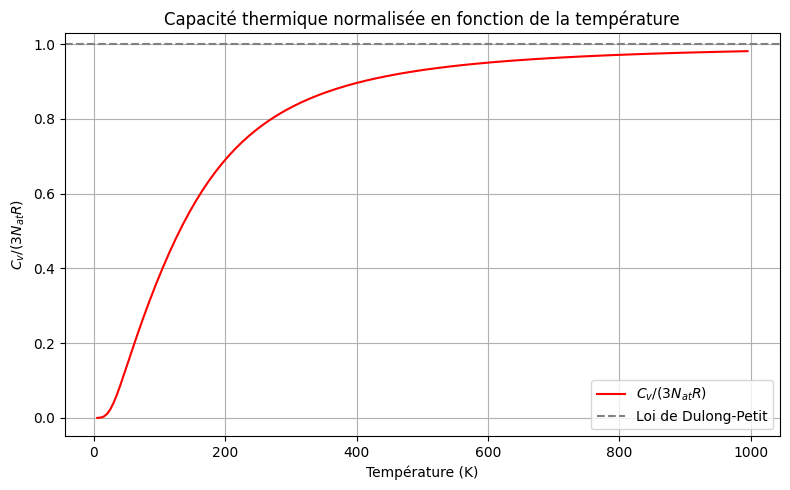

In [4]:
R = 8.314
temps = np.arange(5, 1000, 5)
Nat = len(prim_struc)  
ph_cv = np.array([ph_dos.cv(T) for T in temps])  # en J/mol·K

cv_norm = ph_cv / (3 * Nat * R)

plt.figure(figsize=(8, 5))
plt.plot(temps, cv_norm,color = 'red', label=r"$C_v / (3N_{at}R)$")
plt.axhline(y=1.0, color='gray', linestyle='--', label="Loi de Dulong-Petit")
plt.xlabel("Température (K)")
plt.ylabel(r"$C_v / (3N_{at}R)$")
plt.title("Capacité thermique normalisée en fonction de la température")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

À haute température, la loi de Dulong et Petit prédit que : $ C_v(T) \rightarrow 3N_{\text{at}}R $ 

- À haute température, la courbe devrait tendre vers 1
- À basse température, le $C_v$ chute vers 0


# 3) Modèle d'Einstein

Température d'Einstein optimale : 395 K


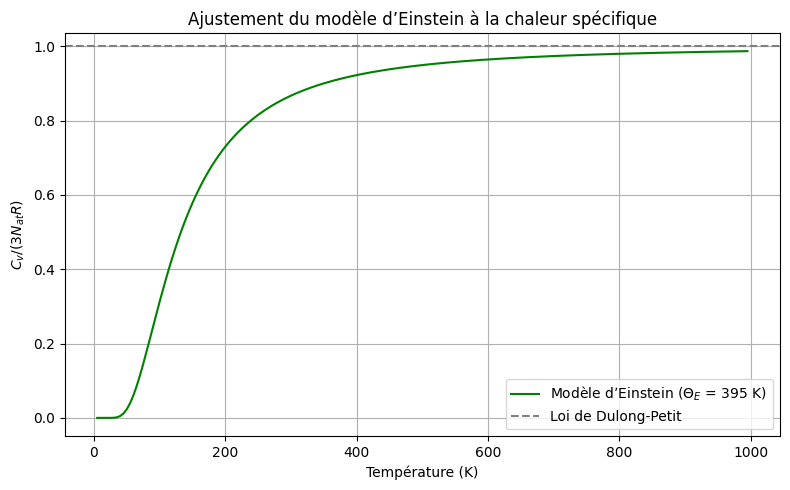

In [5]:
import numpy as np

def cv_einstein(theta_E, T):
    if T == 0:
        return 0
    x = theta_E / T
    try:
        exp_x = np.exp(x)
        denom = np.expm1(x)  # exp(x) - 1
        return (x**2 * exp_x) / (denom**2)  # normalisé par 3N_at R
    except OverflowError:
        return 0 


def erreur_einstein(theta):
    erreur_totale = 0 
    for T, c_exp in zip(temps, cv_norm):
        cv_th = cv_einstein(theta, T)
        ecart_carre = (cv_th - c_exp)**2
        erreur_totale += ecart_carre
    return erreur_totale


theta_E_opt = min(range(1, 1000), key=erreur_einstein)
print("Température d'Einstein optimale :", theta_E_opt, "K")
cv_einstein_curve = [cv_einstein(theta_E_opt, T) for T in temps]


plt.figure(figsize=(8, 5))
plt.plot(temps, cv_einstein_curve, label=fr"Modèle d’Einstein ($\Theta_E$ = {theta_E_opt} K)", color='green')
plt.axhline(1.0, linestyle='--', color='gray', label="Loi de Dulong-Petit")
plt.xlabel("Température (K)")
plt.ylabel(r"$C_v / (3N_{at}R)$")
plt.title("Ajustement du modèle d’Einstein à la chaleur spécifique")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Le modèle d’Einstein propose une description simplifiée des vibrations atomiques dans un solide en supposant que tous les atomes oscillent indépendamment à la même fréquence $ \omega_E $. Cette approche permet de prédire l’évolution de la capacité thermique à volume constant $ C_v $ en fonction de la température.


Nous pouvons introduire la température d’Einstein $ \Theta_E $, définie par : $ k_B \Theta_E = \hbar \omega_E $

où :
- $ k_B $ est la constante de Boltzmann,
- $\hbar$ est la constante de Planck réduite.


Dans ce modèle, la capacité thermique molaire à volume constant est donnée par :

$$
C_v = 3 N_{at} R \left( \frac{\Theta_E}{T} \right)^2 \frac{e^{\Theta_E / T}}{\left(e^{\Theta_E / T} - 1\right)^2}
$$

Pour les hautes températures $T \gg \Theta_E $, on retrouve la limite classique de Dulong et Petit :$  C_v \to 3 N_{at} R $

Pour les basses températures $T \ll \Theta_E$, la capacité thermique chute de manière exponentielle :$  C_v \propto e^{-\Theta_E / T}$

# 3) Modèle de Debye

Température de Debye optimale : 536 K


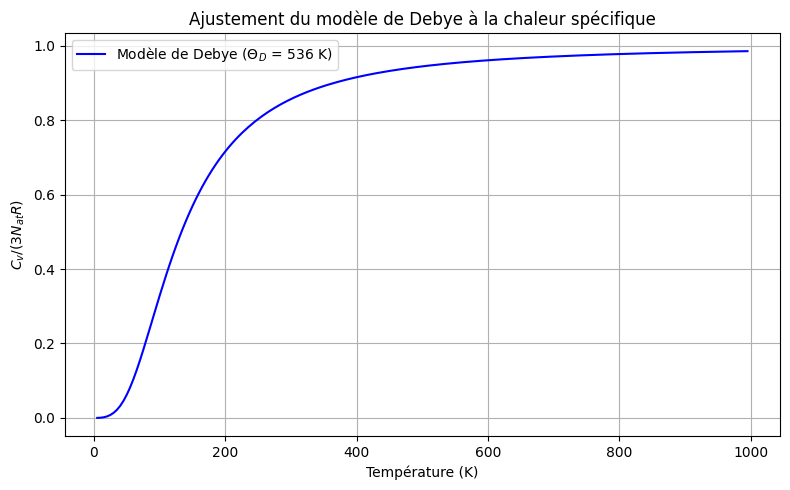

In [6]:
def integrand_debye(x):
    return (x**4 * np.exp(x)) / ((np.exp(x) - 1)**2)

def cv_debye(theta_D, T):
    if T == 0:
        return 0
    integral, _ = quad(integrand_debye, 0, theta_D / T)
    return 3 * (T / theta_D)**3 * integral  # normalisé

def erreur_debye(theta):
    erreur_totale = 0

    for i in range(len(temps)):
        T = temps[i]
        c_exp = cv_norm[i]

        c_th = cv_debye(theta, T)     
        ecart = c_th - c_exp        
        erreur_totale += ecart**2     

    return erreur_totale

theta_D_opt = min(range(1, 1000), key=erreur_debye)
print("Température de Debye optimale :", theta_D_opt, "K")
cv_debye_curve = [cv_debye(theta_D_opt, T) for T in temps]

plt.figure(figsize=(8, 5))
plt.plot(temps, cv_debye_curve, label=fr"Modèle de Debye ($\Theta_D$ = {theta_D_opt} K)", color='blue')
plt.xlabel("Température (K)")
plt.ylabel(r"$C_v / (3N_{at}R)$")
plt.title("Ajustement du modèle de Debye à la chaleur spécifique")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Le modèle de Debye améliore le modèle d’Einstein en prenant en compte le fait que les atomes dans un solide ne vibrent pas tous à la même fréquence. Il considère une distribution continue des fréquences, avec une densité d'états adaptée aux basses fréquences.



La capacité calorifique à volume constant est donnée par :

$$
C_v = \frac{\Omega}{2\pi^2} \cdot 3N_{at} R \int_0^{q_D} \frac{\beta^2 \hbar^2 v^2 q^4 e^{\beta \hbar v q}}{(e^{\beta \hbar v q} - 1)^2} \, dq
$$

où :
- $ \Omega $ est le volume du système,
- $ q $ est le vecteur d’onde,
- $ v $ est la vitesse du son dans le matériau,
- $ \beta  = 1 / (k_B T) $,
- $ N_{at} $ est le nombre d’atomes,
- $ R $ est la constante des gaz parfaits.

En effectuant le changement de variable : $x = \frac{\hbar v q}{k_B T} $

On peut réécrire l'expression de la capacité thermique molaire de manière plus compacte et adaptée au calcul numérique :

$$
C_v = 9 N_{at} R \left( \frac{T}{\Theta_D} \right)^3 \int_0^{\Theta_D / T} \frac{x^4 e^x}{(e^x - 1)^2} \, dx
$$


La température de Debye, définie par :$ k_B \Theta_D = \hbar \omega_D = \hbar v q_D $



# 4) Comparaison des 3 courbes

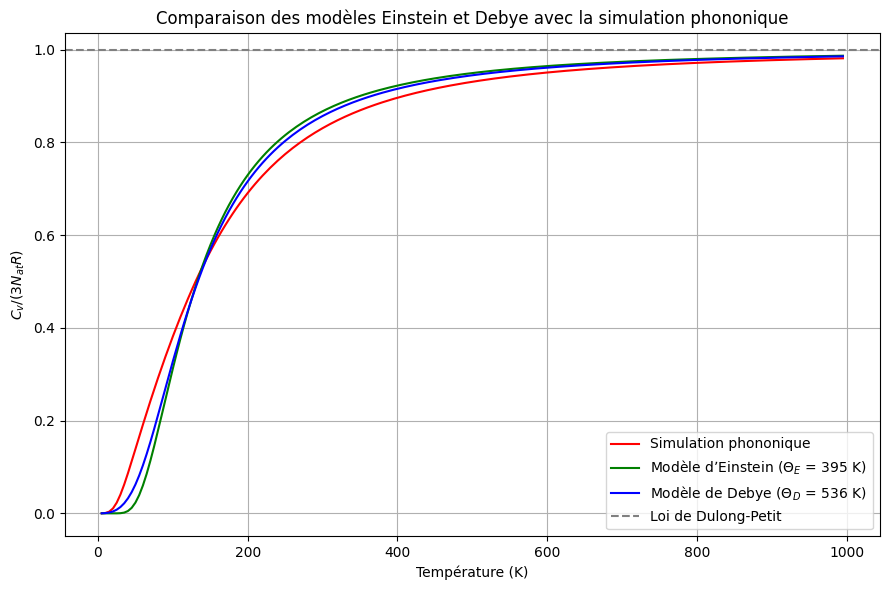

In [7]:
plt.figure(figsize=(9, 6))
plt.plot(temps, cv_norm, label="Simulation phononique", color='red')
plt.plot(temps, cv_einstein_curve, label=fr"Modèle d’Einstein ($\Theta_E$ = {theta_E_opt} K)", color='green')
plt.plot(temps, cv_debye_curve, label=fr"Modèle de Debye ($\Theta_D$ = {theta_D_opt} K)", color='blue')
plt.axhline(1.0, linestyle='--', color='gray', label="Loi de Dulong-Petit")
plt.xlabel("Température (K)")
plt.ylabel(r"$C_v / (3N_{at}R)$")
plt.title("Comparaison des modèles Einstein et Debye avec la simulation phononique")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Le graphique ci-dessus compare la capacité calorifique normalisée $C_v / (3 N_{at} R) $ en fonction de la température pour trois méthodes :

- Simulation phononique (en rouge) : modèle numérique basé sur les densités d’états issues des vibrations réelles du matériau.
- Modèle d’Einstein (en vert), avec $ \Theta_E = 395\, \text{K} $
- Modèle de Debye (en bleu), avec $ \Theta_D = 536\, \text{K} $


À haute température, les trois courbes convergent vers la limite classique de Dulong-Petit :  
  $$
  C_v \to 3 N_{at} R
  $$
 Ce plateau est indiqué par la ligne pointillée horizontale.

À basse température :
  - Le modèle d’Einstein sous-estime clairement la capacité thermique. En effet, il ne capture pas correctement les modes acoustiques à basse fréquence.
  - Le modèle de Debye, en revanche, s'ajuste beaucoup mieux à la simulation phononique. Il reproduit correctement la loi \$ C_v \propto T^3 $ attendue à basse température.

En conclusion, le modèle de Debye fournit une meilleure approximation physique de la capacité thermique, en particulier à basse température. Le modèle d’Einstein  est limité par l’hypothèse d’une fréquence unique.


# 5) Calcul des densités d'état d'états de phonons correspondantes


La fréquence de Debye vaut :  8.227124136950568  [THz]
La fréquence d'Einstein vaut :  11.163895031406339 [THz]
-------------------------------------------------------------------------------------------------------------------


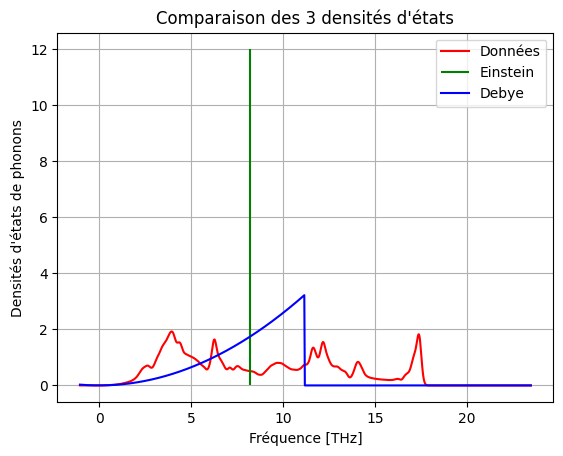

In [8]:
k_B = 1.380649e-23
conv_THz = 1e-12
h_barre = 1.055e-34

freq = ph_dos.frequencies 
dens = ph_dos.densities

omega_e = conv_THz*k_B*theta_E_opt/h_barre
f_e = omega_e/(2*np.pi)

omega_d = conv_THz*k_B*theta_D_opt /h_barre
f_d = omega_d / (2 * np.pi)

print("\nLa fréquence de Debye vaut : ",f_e," [THz]")
print("La fréquence d'Einstein vaut : ",f_d,"[THz]")
print("-------------------------------------------------------------------------------------------------------------------")

dens_d = np.zeros(len(freq))
for i,f in enumerate(freq):
    omega = 2*np.pi*f
    if omega < omega_d:
        dens_d[i] = (9*Nat*(omega)**2/(omega_d**3))

plt.plot(freq, dens,color="red", label="Données")
plt.vlines(f_e, 0, 3 * Nat ,color="green", label = "Einstein")
plt.plot(freq, dens_d*(2*np.pi), color='blue', label="Debye")
plt.title("Comparaison des 3 densités d'états")
plt.ylabel("Densités d'états de phonons")
plt.xlabel("Fréquence [THz]")
plt.legend()
plt.grid()
plt.show()

La densité d’états de phonons décrit le nombre de modes vibratoires accessibles à une fréquence donnée dans un matériau. Elle est notée $g(\omega)$, où $\omega $ représente la fréquence angulaire. Par définition, l’aire sous la courbe de densité d’états doit toujours satisfaire la condition suivante :

$$
\int g(\omega) \, d\omega = 3N_{\text{at}}
$$

En effet, chaque atome peut vibrer indépendamment selon les trois directions de l’espace (x, y, z), ce qui conduit à trois modes vibratoires par atome. Ainsi, pour un système contenant $N_{\text{at}}$ atomes, on doit retrouver au total $3N_{\text{at}}$ modes normaux de vibration. Les modèles d’Einstein et de Debye sont deux approches classiques qui doivent respecter cette contrainte.


Dans le modèle d’Einstein, tous les atomes vibrent à la même fréquence fixe $\omega_E$. Autrement dit, il n’existe qu’un seul mode de vibration, mais ce mode est triplé pour tenir compte des trois directions de vibration par atome. La densité d’états prend alors la forme d’un pic de Dirac :
$$
g_E(\omega) = 3N_{\text{at}} \, \delta(\omega - \omega_E)
$$

Toute la densité est concentrée à $ \omega = \omega_E$. L’intégrale de cette fonction donne bien $ 3N_{\text{at}} $, ce qui respecte la condition d’aire. Graphiquement, cela se traduit par une ligne verticale en $\omega = \omega_E $ d’une hauteur infinie, mais dont l’aire vaut $3N_{\text{at}}$, dans notre cas nous avons $ N_{\text{at}} = 4$, cela donne une aire de 12).


Le modèle de Debye propose une approche plus réaliste à basse fréquence, en supposant une relation de dispersion linéaire entre la fréquence et le vecteur d’onde : $ \omega = vq$, où $v$ est la vitesse du son dans le matériau. Dans ce cadre, les modes sont répartis en fonction de leur fréquence selon une loi quadratique. On opte pour la densité d’états donnée par :

$$
g_D(\omega) = 
\begin{cases}
\displaystyle \frac{9 N_{\text{at}}}{\omega_D^3} \, \omega^2 & \text{si } \omega \leq \omega_D \\
0 & \text{sinon}
\end{cases}
$$

où $\omega_D $ est la fréquence de coupure de Debye, définie de manière à ce que l’aire sous la courbe soit également égale à $ 3N_{\text{at}}$. Cette fonction décrit une parabole croissante jusqu’à $\omega_D$ , au-delà de laquelle la densité est nulle.

En observant le graphique, nous pouvons constater qu’aucun des deux modèles théoriques ne permet de reproduire fidèlement la densité d’états phononique obtenue par calcul. Le modèle d’Einstein est particulièrement simpliste, puisqu’il suppose une fréquence unique pour tous les modes, tandis que le modèle de Debye, bien qu’un peu plus réaliste à basse fréquence, ne tient pas compte des modes optiques présents à haute fréquence. Cela montre que ces modèles reposent sur des hypothèses fortes, souvent faites pour simplifier les calculs.
